# 15. 트랜스포머로 만드는 대화형 챗봇

## 14. 프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜보자.

### 트랜스포머와 인코더 디코더
---

#### 인코더와 디코더 구조 되짚어보기

번역기를 만드는 데 사용한 대표적인 모델인 인코더와 디코더 구조를 되짚어보자.

<img src="./image/translation.png" alt="translation" />

번역기는 인코더와 디코더 두 가지 아키텍처로 구성되어져 있었다. 인코더에 입력 문장이 들어가고, 디코더는 이에 상응하는 출력 문장을 생성한다. 그리고 이를 훈련한다는 것은 결국 입력 문장과 출력 문장 두 가지 병렬 구조로 구성된 데이터셋을 훈련한다는 의미였다.

#### 훈련 데이터셋의 구성(번역)

* 입력 문장 : '저는 학생입니다.'
* 출력 문장 : 'I am a student'

이런 병렬적으로 구성된 데이터셋을 인코더와 디코더로 학습하는 경우는 사실 번역기에만 한정되지는 않는다. 질문에 대해서 대답을 하도록 구성된 데이터셋을 인코더와 디코더 구조로 학습한다면, 주어진 질문에 답변할 수 있는 챗봇 또한 만들 수 있을 것이다.

#### 훈련 데이터셋의 구성(질문-답변)

* 입력 문장 : '오늘의 날씨는 어때?'
* 출력 문장 : '오늘은 매우 화창한 날씨야'

#### 트랜스포머의 인코더와 디코더

트랜스포머 또한 번역기와 마찬가지로 기본적으로 인코더와 디코더 구성을 가지고 있다. 입력 문장을 넣으면 출력 문장을 내뱉고 있는 것이다.

<img src="./image/transformer.png" alt="transformer" />

위의 블랙박스로 가려져 있는 트랜스포머의 내부구조를 열어보면 아래와 같다

<img src="./image/transformer2.png" alt="transformer" />

초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때, 입력 문장은 누적되어져 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적되어져 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조를 갖고 있다.

그리고 그 내부를 조금 더 확대해 보면 아래와 같이 톱니바퀴처럼 맞물려 돌아가는 여러 가지 부품들로 구성되어져 있다.

<img src="./image/transformer3.png" alt="transformer" />

위의 그림에서 적혀져 있는 모듈들을 하나씩 정리해보자.

### 트랜스포머의 입력 이해하기
---
먼저 앞으로 진행하면서 필요한 패키지를 임포트하자.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import urllib.request
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<img src="./image/embedding.png" alt="embeddings" />

많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거친다. 트랜스포머 또한 그 점에서는 다른 모델들과 다르지 않다. 하지만 트랜스포머 모델의 입력데이터 처리에는 RNN 계열의 모델들과 다른 점이 한 가지 있다. 바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다. 그 값은 바로 위 그림에서의 포지셔널 인코딩(positional Encoding)에 해당하는 부분이다.

위 그림에서 인코더의 입력 부분을 조금 더 확대해 본다면 이런 그림이 나올 것이다.

<img src="./image/encoder.png" alt="encoder" />

이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문이다. 트랜스포머가 RNN과 결정적으로 다른 점이 바로 이 부분이다. RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없었다. 그러나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없을지도 모른다. 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것이다.

<img src="./image/positional_encoding.png" alt="Positional Encoding" />

포지셔널 인코딩의 벡터값은 위의 수식에 의해서 정해진다. 사인 함수와 코사인 함수의 그래프를 상기해보면 요동치는 값의 형태를 생각해볼 수 있는데, 트랜스포머는 사인 함수와 코사인 함수의 값을 임베딩 벡터에 더해줌으로써 단어의 순서 정보를 더하여 준다.

위의 두 함수에는 pos, i, $d_{model}$ 등 생소한 변수들이 있다. 위의 함수를 이해하기 위해서는 위에서 본 임베딩 벡터와 포지셔널 인코딩의 덧셈은 사실 임베딩 벡터가 모여 만들어진 문장 벡터 행렬과 포지셔널 인코딩 행렬의 덧셈 연산을 통해 이루어진다는 점을 이해해야 한다.

<img src="./image/matrix.png" alt="Positional Encoding matrix" />

$d_{model}$은 임베딩 벡터의 차원을 의미하고 있고, pos는 입력 문장에서의 임베딩 벡터의 위치를 나타내며, i는 임베딩 벡터 내의 차원의 인덱스를 의미한다. 이렇게 임베딩 행렬과 포지셔널 행렬이라는 두 행렬을 더함으로써 각 단어 벡터에 위치 정보를 더해주게 되는 것이다.



* 한 문장에 같은 단어 A가 여러 번 등장하였다고 가정해보자. 임베딩 문장 행렬에 포지셔널 인코딩을 해주었을 때와 해주지 않았을 때, 트랜스포머가 임베딩 문장 행렬 내의 다수의 A 단어 벡터로부터 얻을 수 있는 정보의 차이가 있다. 같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있다.

포지셔널 행렬을 직접 구현해서 눈으로 확인해보자.

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

행의 크기가 50, 열의 크기가 512인 행렬을 그려보자. 이를테면, 최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 이와 같을 것이다.

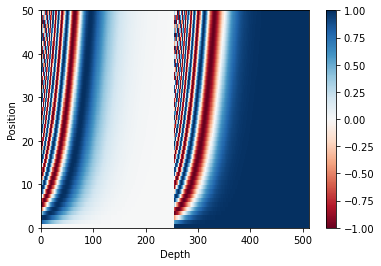

In [3]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

임베딩 벡터의 차원이 256이고 최대 문장의 길이가 30인 텍스트를 입력으로 하는 트랜스포머를 구현한다고 하였을 때, 적절한 포지셔널 인코딩 행렬의 크기를 추측해보고 위에 구현한 포지셔널 인코딩 레이어를 사용해 표현해보자

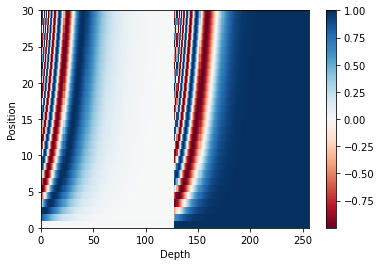

In [4]:
sample_pos_encoding = PositionalEncoding(30, 256)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

실제 논문에서 제시된 그림에서는 다음과 같이 포지셔널 인코딩을 표현하였다.

<img src="./image/positional_encoding2.png" alt="Positional Encoding" />

### 어텐션? 어텐션!
---
트랜스포머의 인코더와 디코더에서 사용하고 있는 개념인 어텐션에 대해서 알아보자

#### 어텐션이란?

어텐션 메커니즘을 그림으로 표현한다면 아래와 같이 표현할 수 있다.

<img src="./image/attention.png" alt="attention" />

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한다. 그리고 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영해준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 __어텐션 값(Attention Value)__라고 한다.

#### 트랜스포머에서 사용된 어텐션

트랜스포머는 총 세 가지의 어텐션을 사용한다.

<img src="./image/transformer_attention.png" alt="transformer_attention" />

첫 번째 그림인 __인코더 셀프 어텐션__은 인코더에서 이루어지고,

두 번째 그림인 __디코더 셀프 어텐션__은 디코더에서 이루어지며,

세 번째 그림인 __인코더-디코더 어텐션__ 또한 디코더에서 이루어진다.

<img src="./image/transformer_attention2.png" alt="transformer_attention" />

위 그림은 트랜스포머의 전체적인 아키텍처에서 각 어텐션이 위치한 곳을 보여준다.

트랜스포머의 어텐션 함수에 사용되는 __쿼리(Query), 키(Key), 밸류(Value)__는 기본적으로 __'단어 (정보를 함축한) 벡터'__이다.

단, 여기서 __'단어 벡터'__란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 __'단어 벡터'__이다.

그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보자.

* __인코더 셀프 어텐션__ : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
* __디코더 셀프 어텐션__ : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
* __인코더-디코더 어텐션__ : 디코더가 잘! 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.

무려 세 가지 어텐션 중 두 가지가 __셀프 어텐션__이다.

자, 그럼 대체 셀프 어텐션이 어떤 의미를 가지고 있으며 트랜스포머에서 왜 중요한지 알아보자

#### 셀프 어텐션(Self Attention)

__셀프 어텐션__이란 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다. 가령, 위에서 언급한 인코더-디코더 어텐션은 서로 다른 단어 목록(인코더 내 단어와 디코더 내 단어) 사이에서 유사도를 구하기에 셀프 어텐션이 아니다.

<img src="./image/self_attention.png" alt="Self Attention" />

위의 그림은 [구글 AI 블로그 포스트](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)에서 가져왔다. 위의 예시 문장을 번역하면 __'그 동물은 길을 건너지 않았다. 왜냐하면 그것은 너무 피곤하였기 때문이다.'__ 라는 의미가 된다. 그런데 여기서 __그것(it)__에 해당하는 것은 과연 __길(street)__일까요? __동물(animal)__일까?

인간은 동물이라는 것을 쉽게 알 수 있지만, 기계는 그렇지 않다. 하지만 셀프 어텐션은 입력 문장 내의 단어들끼리 유사도를 구하여 __그것(it)__이 __동물(animal)__과 연관되었을 확률이 높다는 것을 찾아낸다. 그런데 한 가지 의문이 든다. 유사도는 어떻게 구할까?

### 스케일드 닷 프로덕트 어텐션
---
앞서 어텐션이 단어들 간의 유사도를 구하는 메커니즘이라고 했었다.

그렇다면 유사도를 구하는 방법이 있을 것이다.

트랜스포머에서는 어텐션 값을 구하는 방법으로 아래와 같은 수식을 사용했다.

$$ Attention(Q,K,V)=softmax \left ( \frac{QK^{t}}{\sqrt{d_{k}}} \right )V$$

Q, K, V는 각각 쿼리(Query), 키(Key), 값(Value)를 나타낸다.

앞서 언급했던 어텐션 함수의 정의와 결과값을 다시 상기해보자.

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 __유사도__를 각각 구한다. 그리고 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 이를 최종 결과인 __어텐션 값(Attention Value)__라고 한다.

위 정의와 아래 내용 세 가지만 기억하면 수식을 그림으로 정리할 수 있다.

1. __Q, K, V__는 단어 벡터를 행으로 하는 문장 행렬이다.
2. 벡터의 __내적(dot product)__은 벡터의 __유사도__를 의미한다.
3. 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

---

우선 Q와 K의 전치 행렬을 곱하는 것을 그림으로 표현하면 다음과 같다.

<img src="./image/qkv.png" alt="qkv" />

문장 행렬 Q와 문장 행렬 K를 곱하면 위의 그림과 같은 초록색 행렬을 얻을 수 있다.

위 초록색 행렬이 의미하는 값은 무엇일까? 예를 들어 'am' 행과 'student' 열의 값은 Q 행렬에 있던 'am' 벡터와 K 행렬에 있던 'student 벡터'의 내적값을 의미한다. 결국 각 단어 벡터의 유사도가 모두 기록된 유사도 행렬이 되는 것이다

---

이 유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용한다. 여기까지가 Q와 K의 유사도를 구하는 과정이라고 볼 수 있겠다. 여기에 문장 행렬 V와 곱하면 __어텐션 값(Attention Value)__를 얻는다.

<img src="./image/self_attention2.png" alt="Self Attention" />

결국 이를 모두 하나의 그림으로 표현하면 위와 같다.

$$ Attention(Q,K,V)=softmax \left ( \frac{QK^{t}}{\sqrt{d_{k}}} \right )V$$

이 수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 __스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)__이라고 한다. 유사도를 구하는 방법이 스케일드 닷 프로덕트(scaled dot product)였기 때문에 이런 이름이 붙은 것이다.

만약에 분모에 특정 값을 나눠주는 부분을 사용하지 않았다면 어텐션의 이름은 무엇일까? 그 어텐션은 당연히 __닷 프로덕트 어텐션(dot product attention)__이라고 부른다.

#### 구현하기

스케일드 닷 프로덕트 어텐션 함수를 구현해보자.

In [5]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

이 글에서 앞으로 어텐션을 수행한다고 한다면, 스케일드 닷 프로덕트 어텐션을 의미한다.

### 머리가 여러 개인 어텐션
---
<img src="./image/hydra.png" alt="hydra" width="30%"/>

그리스 로마 신화에 등장하는 히드라라는 괴물이다. 머리가 여러 개인 이 괴물은 여러 곳으로 동시에 시선을 둘 수 있었기 때문에 시선의 사각지대가 없어서 처치하기 어려운 괴물이다. 결국 헤라클레스가 히드라의 머리를 하나씩 제거한 뒤에야 무찌를 수 있었다.

다른 비유를 하나 들어보겠다. 굉장히 어려운 문제가 가득한 시험지를 받았을 때 '혼자가 아니라 옆에서 누군가 같이 풀어준다면 좀 더 좋은 성적을 받을 텐데'하고 누구나 한 번쯤 상상해보았을 것이다.

이런 이야기는 현실에서는 상상에 불과하지만, 기계가 할 수 있도록 해줄 수는 있다.

#### 병렬로 어텐션 수행하기

트랜스포머에서 `num_heads`라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지, 다시 말해 병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터이다.
<img src="./image/parallel.png" alt="parallel" />

앞서 포지셔널 인코딩에서 `d_model`은 임베딩 벡터의 차원이라고 언급한 바 있다. 결국 트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, `d_model`을 열의 크기로 가진다.

트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads`의 수만큼 쪼개서 어텐션을 수행하고, 이렇게 얻은 `num_heads`의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate한다.

위의 그림은 `num_heads`가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 `d_model`이 된다.

각자 문제지를 나눠서 푼 후에 마지막에 다시 결과를 합친다고 비유해볼 수도 있겠다.

* 논문에서 d_model은 512의 값을 가졌다고 하고, num_heads는 8의 값을 가졌다고 한다. 그렇다면, 연결하기 전 8개의 어텐션 값(Attention Value) 행렬의 열의 크기는 512/8 = 64 차원이다.

#### 멀티-헤드 어텐션

이렇게 병렬로 어텐션을 수행하면 얻을 수 있는 효과는 무엇일까?

<img src="./image/multihead.png" alt="multihead" />

위 그림은 `num_heads`의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여준다. 다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있다. 예를 들어 위 그림에서라면 `it_`이라는 토큰이 `animal_`과 유사하다고 보는 관점과 `street_`과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻이다.

이와 같이 어텐션을 병렬로 수행하는 것을 __멀티 헤드 어텐션__이라고 부른다.

#### 구현하기

__멀티 헤드 어텐션__을 구현하면 다음과 같다.

내부적으로는 __스케일드 닷 프로덕트 어테션 함수__를 호출한다.

In [6]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                        (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

### 마스킹
---
__마스킹(Masking)__이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.

트랜스포머에서는 어텐션을 위해서 크게 두 가지 마스킹을 사용한다고 한다.

#### 패딩 마스킹(Padding Masking)

첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법이다.

자연어 처리에서 패딩(Padding)이란 어떤 개념일까?

<img src="./image/padding.png" alt="Padding" />

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다.

위 그림은 케라스의 pad_sequences()를 사용하여 패딩을 하는 과정을 시각화한 그림이다.

그런데 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있다. 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크한다.

다음은 패딩 마스킹을 구현한 함수이다.



In [7]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 리턴한다.

두 개의 정수 시퀀스를 입력으로 해보고, 각각 어떤 결과가 나오는지 확인하자.

In [8]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


두 정수 시퀀스에 대해서 각각 결과가 출력되는데, 오직 숫자가 0인 위치에서만 숫자 1이 나오고 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다.

어텐션 연산 시에 __패딩 마스킹__을 참고하면 불필요하게 숫자 0을 참고하지 않게 할 수 있을 것이다.

#### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)

순환 신경망, RNN과 트랜스포머는 문장을 입력받을 때 입력받는 방법이 전혀 다르다.

RNN은 __step__이라는 개념이 존재해서 각 __step__마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다. 그리고 이 특징 때문에 추가적인 __마스킹(Masking)__을 필요하다.

#### RNN
RNN으로 다음 단어를 예측해가면서 문장을 생성해내는 과정을 보자.

다시 말해 RNN으로 디코더를 구현했을 경우이다.

<img src="./image/rnn.png" alt="RNN" />

RNN은 구조상으로 다음 단어를 만들어 갈 때, 자신보다 앞에 있는 단어들만 참고해서 다음 단어를 예측한다. 위의 그림을 참고로 각 단계에서 다음 단어 예측 과정을 서술하면 다음과 같다.

* __첫 번째 step__
    - 현재까지의 입력 : what → 출력 : is

* __두 번째 step__
    - 현재까지의 입력 : what is → 출력 : the

* __세 번째 step__
    - 현재까지의 입력 : what is the → 출력 problem

#### 트랜스포머
하지만 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법이다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹한다.

<img src="./image/transformer4.png" alt="transformer" />

위의 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있다. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있다. 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬을 살펴보자.

예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 `<s>`, `<나는>`, `<행복을>`, `<찾고>`까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있다. 즉, 유사도를 구할 수 없도록 해놓았다. 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같다.

In [9]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

직접 입력을 넣어 테스트해보자.

In [10]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있다. 그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야한다. 그래서 `create_look_ahead_mask()` 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있다.

숫자 0이 포함되었을 경우에도 테스트해보자.

In [11]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


###  인코더
---
트랜스포머의 입력, 그리고 트랜스포머 내부에서 일어나는 어텐션에 대해서도 간단히 정리해봤다. 이제 트랜스포머의 인코더를 설계해보자.

<img src="./image/encoder2.png" alt="encoder" />

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어진다.<br>
바로 __셀프 어텐션__과 __피드 포워드 신경망__이다. 셀프 어텐션은 __멀티 헤드 어텐션__으로 병렬적으로 이루어진다.

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같다. 함수 내부적으로 첫 번째 서브 층와 두 번째 서브 층을 구현하고 있다.

In [12]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

<img src="./image/encoder3.png" alt="encoder" />

#### 인코더 층을 쌓아 인코더 만들기

이렇게 구현한 인코더 층을 __임베딩 층(Embedding layer)__과 __포지셔널 인코딩(Positional Encoding)__을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

인코더와 디코더 내부에서는 각 서브층 이후에 훈련을 돕는 __Layer Normalization__이라는 테크닉이 사용되었다. 위 그림에서는 __Normalize__라고 표시된 부분에 해당된다.

트랜스포머는 하이퍼파라미터인 __num_layers__ 개수의 인코더 층을 쌓는다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [13]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더
---
디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡하다. 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다르다.

#### 디코더 층

<img src="./image/decoder.png" alt="decoder" />

첫 번째는 __셀프 어텐션__, 두 번째는 __인코더-디코더 어텐션__, 세 번째는 __피드 포워드 신경망__이다. __인코더-디코더 어텐션__은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

<img src="./image/decoder2.png" alt="decoder" />

인코더의 __셀프 어텐션__과 마찬가지로 디코더의 __셀프 어텐션__, __인코더-디코더 어텐션__ 두 개의 어텐션 모두 __스케일드 닷 프로덕트 어텐션__을 __멀티 헤드 어텐션__으로 병렬적으로 수행한다.

디코더의 세 개의 서브 층을 내부적으로 구현한 디코더의 함수는 다음과 같다.

In [14]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

#### 디코더 층을 쌓아 디코더 만들기

이렇게 구현한 디코더의 층은 __임베딩 층(Embedding layer)__과 __포지셔널 인코딩(Positional Encoding)__을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 __num_layers__ 개수의 디코더 층을 쌓는다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [15]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

이제 인코더 층과 디코더 층을 각각 함수로 구현하였다.

이를 하나로 조합하여 트랜스포머 모델을 만들 수 있을 텐데, 우선 그 전에 여기서 사용할 챗봇 데이터를 로드하고, 전처리해보겠다.

### Step 1. 데이터 수집하기
---
한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용한다.

이 데이터는 아래의 링크에서 다운로드할 수 있다.

* [songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData%20.csv)

```bash
# wget으로 데이터 다운로드
$ wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv
```

### Step 2. 데이터 전처리하기
---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있다.

In [16]:
urllib.request.urlretrieve("https://github.com/songys/Chatbot_data/raw/master/ChatbotData%20.csv", filename="ChatBotData.csv")
data = pd.read_csv('ChatBotData.csv')

data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [17]:
print('챗봇 샘플의 개수 :', len(data))

챗봇 샘플의 개수 : 11823


Null 값이 있는지 확인해보자.

In [18]:
print(data.isnull().sum())

Q        0
A        0
label    0
dtype: int64


이번 전처리는 __정규 표현식(Regular Expression)__을 사용하여 __구두점(punctuation)__을 제거하여 단어를 __토크나이징(tokenizing)__하는 일에 방해가 되지 않도록 정제하는 것을 목표로 한다.

In [19]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    return sentence

In [20]:
questions = []
for sentence in data['Q']:
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    questions.append(sentence)
    
answers = []
for sentence in data['A']:
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

이렇게 로드한 데이터의 샘플 수를 확인해보자

In [21]:
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [22]:
print(questions[:100])
print(answers[:100])

['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'PPL 심하네', 'SD카드 망가졌어', 'SD카드 안돼', 'SNS 맞팔 왜 안하지ㅠㅠ', 'SNS 시간낭비인 거 아는데 매일 하는 중', 'SNS 시간낭비인데 자꾸 보게됨', 'SNS보면 나만 빼고 다 행복해보여', '가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다 .', '가스비 비싼데 감기 걸리겠어', '가스비 장난 아님', '가장 확실한 건 뭘까 ?', '가족 여행 가기로 했어', '가족 여행 고고', '가족 여행 어디로 가지 ?', '가족 있어 ?', '가족관계 알려 줘', '가족끼리 여행간다 .', '가족들 보고 싶어', '가족들이랑 서먹해', '가족들이랑 서먹해졌어', '가족들이랑 어디 가지 ?', '가족들이랑 여행 갈거야', '가족여행 가야지', '가족이 누구야 ?', '가족이랑 여행 가려고', '가족한테 스트레스 풀었어', '가출할까 ?', '가출해도 갈 데가 없어', '간만에 떨리니까 좋더라', '간만에 쇼핑 중', '간만에 휴식 중', '간식 뭐 먹을까', '간식 추천', '간장치킨 시켜야지', '간접흡연 싫어', '갈까 말까 고민 돼', '갈까 말까 ?', '감 말랭이 먹고 싶다 .', '감 말랭이 먹어야지', '감기 같애', '감기 걸린 것 같아', '감기 기운이 있어', '감기 들 거 같애', '감기가 오려나', '감기약이 없어', '감기인거 같애', '감미로운 목소리 좋아', '감정이 쓰레기통처럼 엉망진창이야', '감정컨트롤을 못하겠어', '감정컨트롤이 안돼', '감히 나를 무시하는 애가 있어', '갑자기 나쁜 생각이 막 들더라', '갑자기 눈물 나', '갑자기 물어봐서 당황했어', '갑자기 불편한 사이가 된 거 같아', '강렬한 첫인상 남겨야 

임의로 22번째 샘플(인덱스 상으로는 21번 샘플)을 출력해서 잘 저장은 되었는지, 그리고 전처리 과정에서 의도했던 전처리가 진행되었는지 확인해보자

In [23]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


### Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 `SubwordTextEncoder`를 그대로 사용해보자.

#### 단어장(Vocabulary) 만들기

In [24]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

이때 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해준다. 이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여하면 될 것이다.

In [25]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

시작 토큰과 종료 토큰에 부여된 정수를 출력해보자.

In [26]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8178]
END_TOKEN의 번호 : [8179]


각각 8178과 8179라는 점에서 현재 단어장의 크기가  8178(0번부터  8178번)이라는 의미이다.

두 개의 토큰을 추가해주었기 때문에 단어장의 크기도 +2임을 명시해주어야 한다.

In [27]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8180


위에서 `tensorflow_datasets`의 `SubwordTextEncoder`를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, `tokenizer.encode()`로 각 단어를 정수로 변환할 수 있고 또는 `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

예를 들어서 22번째 샘플을 `tokenizer.encode()`의 입력으로 사용해서 변환 결과를 보자.

In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5766, 611, 2495, 4167]
정수 인코딩 후의 21번째 답변 샘플: [2359, 7516, 7, 6279, 97, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 __정수 인코딩__을 수행한다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 __패딩(padding)__한다.

In [29]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [30]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었다. 단어장의 크기와 샘플의 개수를 확인해 보겠다.

In [31]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8180
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


__tf.data.Dataset API__는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 한다.

이때, 디코더의 입력과 실제값(레이블)을 정의해주기 위해서는 __교사 강요(Teacher Forcing)__이라는 언어 모델의 훈련 기법을 이해해야만 한다. 아래의 글을 통해 교사 강요에 대해 알아보자.

* [위키독스: RNN 언어 모델](https://wikidocs.net/46496)

* 교사 강요를 하지 않은 경우, 잘못된 예측이 다음 시점(time step)의 입력으로 들어가면서 연쇄적으로 예측 정확도에 영향을 미친다.

이전 자신의 출력이 현재 자신의 상태를 결정하는 모델을 __자기회귀 모델(auto-regressive model, AR)__이라고 한다. 앞서 교사 강요를 이해하기 위해 읽었던 글에 등장한 RNN 언어 모델은 대표적인 자기 회귀 모델의 예이며, 트랜스포머의 디코더 또한 자기회귀 모델이다.

트랜스포머 디코더에서도 __교사 강요(Teacher Forcing)__를 적용한다.


>만약, answers의 한 샘플이 다음과 같았다고 해보자.
>
>샘플 : '`<START_TOKEN> I AM A STUDENT <END_TOKEN> <PAD> <PAD> <PAD> <PAD>`'
>
>`<START_TOKEN>`은 문장의 시작을 의미하는 시작 토큰, <br>
>`<END_TOKEN>`은 문장의 끝을 의미하는 종료 토큰 <br>
>`<PAD>`는 패딩을 위해 사용되는 패딩 토큰이다.
>
>교사 강요를 적용하기 위해서 위 샘플을 디코더의 입력과 레이블로 사용한다고 하였을 때,
>각각 어떻게 수정해서 입력과 레이블로 사용해야 할까?

* 입력 : `<START_TOKEN>` I AM A STUDENT `<END_TOKEN>` `<PAD>` `<PAD>` `<PAD>`
* 레이블 : I AM A STUDENT `<END_TOKEN>` `<PAD>` `<PAD>` `<PAD>` `<PAD>`

질문과 답변의 쌍을 __tf.data.Dataset API__의 입력으로 사용하여 파이프라인을 구성한다. 이때, 교사 강요를 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용한다.

In [32]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현한다.

#### 이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의한다.

In [33]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 모델 생성

`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터값이다.

논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.

In [34]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 256)    3148288     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 손실 함수(Loss function)

레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [35]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

#### 커스텀된 학습률(Learning rate)

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터이다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용한다. 논문에 나온 공식은 다음과 같다.

$$\mathit{lrate=d_{model}^{-0.5}\cdot min(step\_num^{-0.5},step\_num\cdot warmup\_steps^{-1.5})}$$

In [36]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

그러면 방금 정의한 커스텀 학습률 스케줄링 계획을 시각화해 봅시다. 위에 언급한 수식은 $\mathit{step\_num^{-0.5}}$에 비례하는 부분과 $\mathit{step\_num}$에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다. 그래서 학습 초기에는 learning_rate가 $\mathit{step\_num}$에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.

Text(0.5, 0, 'Train Step')

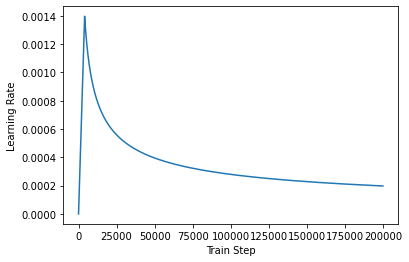

In [37]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일한다.

In [38]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 훈련하기

총 20 에포크를 학습한다.

In [39]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 12s 67ms/step - loss: 1.4588 - accuracy: 0.0199
Epoch 2/20
185/185 [==============================] - 12s 67ms/step - loss: 1.1859 - accuracy: 0.0486
Epoch 3/20
185/185 [==============================] - 12s 67ms/step - loss: 1.0072 - accuracy: 0.0507
Epoch 4/20
185/185 [==============================] - 13s 68ms/step - loss: 0.9282 - accuracy: 0.0543
Epoch 5/20
185/185 [==============================] - 13s 72ms/step - loss: 0.8692 - accuracy: 0.0577
Epoch 6/20
185/185 [==============================] - 13s 68ms/step - loss: 0.8090 - accuracy: 0.0618
Epoch 7/20
185/185 [==============================] - 12s 65ms/step - loss: 0.7431 - accuracy: 0.0682
Epoch 8/20
185/185 [==============================] - 12s 66ms/step - loss: 0.6699 - accuracy: 0.0757
Epoch 9/20
185/185 [==============================] - 12s 67ms/step - loss: 0.5903 - accuracy: 0.0844
Epoch 10/20
185/185 [==============================] - 12s 65ms/step - loss: 0.508

### Step 5. 모델 평가하기
---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만든다.

#### 챗봇 테스트하기
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 `decoder_inference()` 함수를 만든다.

In [40]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 `decoder_inference()` 함수를 호출하여 챗봇의 대답을 얻는 `sentence_generation()` 함수를 만든다.

In [41]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

임의의 문장으로부터 챗봇의 대답을 얻어보자.

In [42]:
sentence_generation('책읽자')

입력 : 책읽자
출력 : 눈꺼풀의 무게를 이겨내세요 .


'눈꺼풀의 무게를 이겨내세요 .'

In [43]:
sentence_generation("배고파")

입력 : 배고파
출력 : 맛난 거 드세요 .


'맛난 거 드세요 .'

In [44]:
sentence_generation("사랑해")

입력 : 사랑해
출력 : 상대방에게 전해보세요 .


'상대방에게 전해보세요 .'

In [45]:
sentence_generation("이별했어요")

입력 : 이별했어요
출력 : 힘든 결정이었겠어요 .


'힘든 결정이었겠어요 .'

In [46]:
sentence_generation("안녕하세요")

입력 : 안녕하세요
출력 : 안녕하세요 .


'안녕하세요 .'

In [53]:
sentence_generation(input())

이름이 뭐야?
입력 : 이름이 뭐야?
출력 : 위로봇이요 .


'위로봇이요 .'

In [54]:
sentence_generation(input())

사랑니 뺐어
입력 : 사랑니 뺐어
출력 : 아프겠어요 .


'아프겠어요 .'

In [61]:
sentence_generation(input())

어떤 주식 살까?
입력 : 어떤 주식 살까?
출력 : 내가 어떻게 생각하는지가 중요해요 .


'내가 어떻게 생각하는지가 중요해요 .'

In [63]:
sentence_generation(input())

sentence_generation(input())
입력 : sentence_generation(input())
출력 : 상대에 대한 예의가 없네요 .  자신을 돌보길 바랄게요 .


'상대에 대한 예의가 없네요 .  자신을 돌보길 바랄게요 .'

오~ㅋㅋㅋㅋ 실수로 코드를 넣었는데 흥미로운 결과가 나왔다.

In [66]:
sentence_generation(input())

너 결혼했니?
입력 : 너 결혼했니?
출력 : 저는 있어요 .


'저는 있어요 .'

결혼까지 했구나ㅋㅋㅋ

### 회고
---
* 개념이 다양하여 완벽하게 이해는 못했지만 대략적으로 어떻게 구성되는지 알게되었다.
* 확실히 자연어 분야가 결과물 보는 재미가 더 있는 것 같다ㅋㅋㅋ
* 영어 데이터 셋과 한국어 데이터 셋이 달라서 파일 불러오는 것부터 헤멧지만 구글링을 통해서 잘 해결하였다.
* 한국어 데이터 셋에 맞게 전처리를 진행하는 과정에서 함수를 사용하지 않고 `for`문을 사용했다.
* 그 이후에 전처리 함수를 사용하는 부분이 있기 때문에 함수 정의는 해놓았다.
* 꽤 좋은 퀄리티의 답변들이 나온것 같아 뿌듯하다.

### 루브릭
---
* 한국어 전처리를 통해 학습 데이터셋을 구축하였다.<br>
(_공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다._)

    * __공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 한국어 데이터셋에 맞게 적절히 진행되었다.__

* 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.<br>
( _구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다._)
    
    * __모델 학습이 진행될수록 loss 값은 줄어들고, accuracy 값은 상승하였다.__

* 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.<br>
(_한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다._)
    
    * __그럴듯한 한국어 문장으로 답변하였다.__